### An Introduction to Qiskit Runtime Primitives Version 2 with Chris Wood: Qiskit Summer School 2024

#### Sampler V2
- Low-level execution of circuits
- Returns single-shot measurement outcomes
- Circuits should include measurements
- The **Sampler** primitive is a low-level primitive for the execution of circuits and obtaining raw measurement outcomes for each shot
- The Sampler primitive API is defined by its run method
    ```
    Sampler.run(
        pubs: list[SamplerPubLike],
        shots: int | None = None,
    ) -> Job[SamplerResult]
    ```
- It can accept a list of 1 or more input programs represented as sampler **Primitive Unified Blocs** (pubs)
- Optional specification of the number of **shots** to run the pubs for

#### Primitive Unified Blocs
- The Primitive Unified Bloc (pub) program input for the sampler is in general a tuple
    ```
    pub = (
        circuit [required],
        parameter_values [optional],
        shots [optional]
    )
    ```
- **Circuit**: An ISA `QuantumCircuit` containing 1 or more `ClassicalRegister` and `measure` instructions
- **Parameter Values**: A tensor (ND-array) of sets of parameter values to evaluate a parametric circuit with
- **Shots**: The number of samples or repetitions to measure the circuit for each set of parameter values
- **Allowed pub-Like inputs**: Because of the optional arguments the following are all valid input pubs for the sampler
    1. `(parametric_isa_circuit, parameter_values, shots)`
    2. `(parametric_isa_circuit, parameter_values)`
    3. `(non_parametric_isa_circuit, None, shots)`
    4. `(non_parametric_isa_circuit, )`



In [4]:
# Example: Run a simple Bell-state measurement circuit
# Load runtime service account and select a backend
from qiskit_ibm_runtime import QiskitRuntimeService

# Load saved runtime account
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_brisbane")

/tmp/ipykernel_1233297/2655886467.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


In [5]:
backend.num_qubits

127

In [8]:
# Create a circuit and transpile to a backend ISA circuit
from qiskit import QuantumCircuit, transpile

# Create a Bell circuit
bell_meas = QuantumCircuit(2)
bell_meas.h(0)
bell_meas.cx(0,1)
bell_meas.measure_all()

# Transpile to an ISA circuit for the intended backend
isa_bell_meas = transpile(bell_meas, backend)

# Construct pub and run
pub_bell_meas = (isa_bell_meas,)

In [9]:
# Initialize a Sampler primitive and run pub
from qiskit_ibm_runtime import SamplerV2

# Initialize a sampler for the backend and run
sampler = SamplerV2(backend)
job_bell_meas = sampler.run([pub_bell_meas], shots=10)

# Extract results
result_bell_meas = job_bell_meas.result()
data_bell_meas = result_bell_meas[0].data
data_bell_meas

DataBin(meas=BitArray(<shape=(), num_shots=10, num_bits=2>))

#### PubResult Class
When run a Sampler Job will return a `PrimitiveResult` object containing an ordered list of `PubResult`s corresponding to each of the input pubs
- `PubResult`: A data container of a single input Pub's execution results
- `PubResult.data`: Contains the measurement outcome data for all classical registers in the input Pub's circuit
- `PubResult.metadata`: Contains any additional metadata that a primitive might record

#### DataBin Class
The `PubResult.data` is a container called a `DataBin`
- A `DataBin` which stores the outcomes of measurements in `ClassicalRegister` in the Pub circuit
- Register results are accessed via name either as attributes, or as a mapping
- Each register's data is stored in a `BitArray` container

#### Accessing Measurement Data
- The `BitArray` class stores the single-shot outcomes of all classical registers
- `BitArray` is an ND-array like object with the following attributes:
    - **shape**: given by the input Pub parameter shape
    - **num_bits**: the size of the input circuit's classical register
    - **num_shots**: the number of shots per parameterization
    - **array**: the internal result data as a packed array of uint8 (byte) values

In [10]:
bits = data_bell_meas.meas
print("shape:", bits.shape)
print("num_bits:", bits.num_bits)
print("num_shots:", bits.num_shots)
print("array:\n", bits.array)

shape: ()
num_bits: 2
num_shots: 10
array:
 [[1]
 [0]
 [3]
 [0]
 [3]
 [0]
 [0]
 [3]
 [0]
 [3]]


In [11]:
bitstrings = bits.get_bitstrings()
print(bitstrings)

['01', '00', '11', '00', '11', '00', '00', '11', '00', '11']


In [12]:
counts = bits.get_counts()
print(counts)

{'01': 1, '00': 5, '11': 4}


#### Instruction Set Architecture (ISA) Circuits

**What is an ISA circuit?**

- An ISA circuit is a `QuantumCircuit` satisfying:
    1. The same *number of qubits* as a device
    2. Only contains *basis gates* for a device
    3. Satisfies the *connectivity* of a device
- If you are used to working with abstract or logical circuits, you will typically obtain an ISA circuit via *transpilation* to a target or backend
    

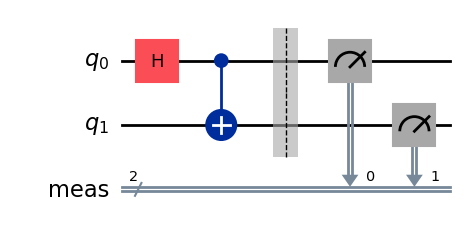

In [13]:
bell_meas.draw("mpl")

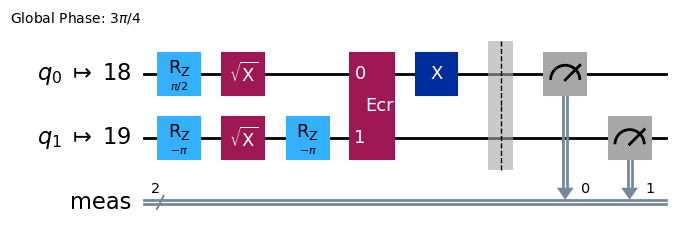

In [14]:
isa_bell_meas.draw("mpl")

#### Parametric Circuits

**What is a parametric circuit?**

A parametric circuit (ISA or abstract) is a circuit that contains *unbound parameter* values

**The shape of a Pub and PubResult**

A sampler Pub shape is given the tensor shape its parameterizations to be evaluated
- A non-parametric Pub has shape ()
- If an ISA circuit has K parameters and (N,K) shape parameter values, it has shape(N,)
- A parametric Pub can be converted to a list of non-parametric Pubs by binding all parameter values

In [21]:
# Example: Control 2-qubit entanglement via parameter
import numpy as np
from qiskit.circuit import Parameter

# Parameterized bell circuit
theta = Parameter("θ")
par_bell_meas = QuantumCircuit(2)
par_bell_meas.ry(theta, 0)
par_bell_meas.cx(0,1)
par_bell_meas.measure_all()

# Parameter values to evaluate with 20 theta values
param_vals = np.linspace(0, np.pi, 20)

# Transpile to an ISA circuit for the intended backend
isa_par_bell_meas = transpile(par_bell_meas, backend)

# Construct Pub and run
# Pub and result shape is (20,)
pub_par_bell_meas = (isa_par_bell_meas, param_vals)
job_par_bell_meas = sampler.run([pub_par_bell_meas], shots=1000)
result_par_bell_meas = job_par_bell_meas.result()

# Extract creg data
bits = result_par_bell_meas[0].data.meas
bits

BitArray(<shape=(20,), num_shots=1000, num_bits=2>)

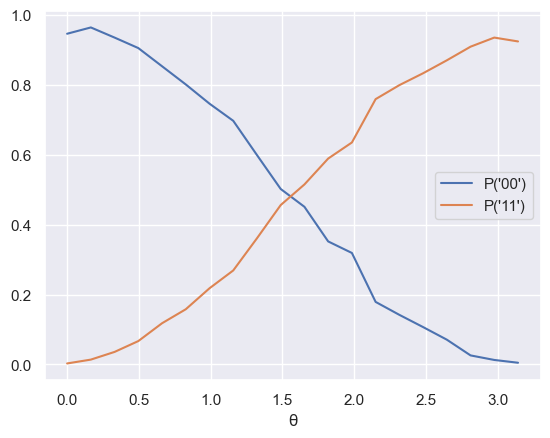

In [24]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

# Compute the probability of "00" outcome and "11" outcome
p0s = np.sum(bits.array == 0, axis=1) / bits.num_shots
p1s = np.sum(bits.array == 3, axis=1) / bits.num_shots

plt.plot(param_vals, p0s, label="P('00')")
plt.plot(param_vals, p1s, label="P('11')")
plt.xlabel("θ")
plt.legend()
plt.show()

#### Sampler V2 Shots

**Specifying the number of shots**

There are multiple ways to specify shots when running the Sampler.
The order of resolution for these values is given by:

1. If a Pub specifies shots it will be used
2. If run kwarg specifies shots, it will be used in all Pubs *that do not specify shots*
3. If no run kwarg is provided all Pubs without shots will use a default value chosen by the Sampler

For the IBM runtime Sampler the default value is 4096 (1024?).

In [27]:
# We will use a fake backend for these shots examples
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Use a local fake backend
fake_backend = FakeManilaV2()

# Initialize a "fake" sampler for the fake backend
fake_sampler = SamplerV2(fake_backend)

# Transpile the Bell circuit to an ISA circuit for the fake backend
fake_isa_bell_meas = transpile(bell_meas, fake_backend)

In [29]:
# 1. All shots in Pub
pub1a = (fake_isa_bell_meas, None, 100)
pub1b = (fake_isa_bell_meas, None, 200)

result1 = fake_sampler.run([pub1a, pub1b], shots=1000).result()

for i, res in enumerate(result1):
    print(f"Pub {i}: num_shots = {res.data.meas.num_shots}")

Pub 0: num_shots = 100
Pub 1: num_shots = 200


In [30]:
# 2. Fall back to `run` shots
pub2a = (fake_isa_bell_meas,)
pub2b = (fake_isa_bell_meas, None, 200)

result2 = fake_sampler.run([pub2a, pub2b], shots=1000).result()

for i, res in enumerate(result2):
    print(f"Pub {i}: num_shots = {res.data.meas.num_shots}")

Pub 0: num_shots = 1000
Pub 1: num_shots = 200


In [31]:
# 3. Fall back to default shots
pub3a = (fake_isa_bell_meas,)
pub3b = (fake_isa_bell_meas, None, 200)

result3 = fake_sampler.run([pub3a, pub3b]).result()

for i, res in enumerate(result3):
    print(f"Pub {i}: num_shots = {res.data.meas.num_shots}")

Pub 0: num_shots = 1024
Pub 1: num_shots = 200


#### Estimator V2

**Estimator Primitive**
- Higher level execution for algorithms and applications
- Returns expectation values of observables
- Circuit should NOT include measurements

The **Estimator** primitives is a higher-level primitive than the Sampler.
- Used for evaluating estimates of *expectation values* on the state prepared by a circuit
- The **Estimator** primitive API is defined by its run method
    ```
    Estimator.run(
        pubs: list[EstimatorPub],
        precision: float | None = None,
    ) -> Job[EstimatorResult]
    ```
- It can accept a list of 1 or more input programs represented as estimator Pubs
- Optional specification of the desired *precision* of expectation value estimates

#### Estimator Pubs

**Primitive Unified Blocs**

The Primitive Unified Bloc (Pub) program input for the estimator is in general a tuple:
```
pub = (
    circuit [required],
    observables [required],
    parameter_values [optional],
    precision [optional],
)
```

**Allowed Pub-like inputs**

Because of the optional arguments the following are all valid inputs for the estimator:

1. `(parametric_isa_circuit, isa_observables, parameter_values, precision)`
2. `(parametric_isa_circuit, isa_observables, parameter_values)`
3. `(non_parametric_isa_circuit, isa_observables, None, precision)`
4. `(non_parametric_isa_circuit, isa_observables)`

#### Estimator Observables

**Representing Observables**

- An observable is a *Hermitian operator* represented as linear combinations of Pauli operators
- *Single Pauli* operators can be represented as:
    - A string containing I, X, Y, Z terms
    - A `quantum_info.Pauli` object
- A *list of Pauli* operators can be represented as:
    - `list[Pauli]`
    - `quantum_info.PauliList`
- A *Hamiltonian* or other operator can be represented as a `quantum_info.SparsePauliOp`


In [32]:
## Create an ISA Circuit
from qiskit_ibm_runtime import EstimatorV2

# Create a Bell circuit
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0,1)

# Transpile to an ISA circuit for the intended backend
isa_bell = transpile(bell, backend)

## Create an ISA observable
import qiskit.quantum_info as qi

# Create an observable
obs = qi.SparsePauliOp(["ZZ"])

# Transpile to ISA observable for intended ISA circuit
isa_obs = obs.apply_layout(isa_bell.layout)

#### Estimator V2 Results

**Estimator DataBin**

Like a sampler, an Estimator job will contain a `PrimitiveResult` with a list of `PubResults` for each input Pub.

Instead of measure outcomes its `DataBin` contains fields:
- **evs**: The mean expectation value estimates for all input Pub parameter values and observables
- **stds**: The standard error of the mean of expectation value estimates

In [33]:
## Run an Estimator Pub

# Construct Estimator
estimator = EstimatorV2(backend)

# Construct Pub and run
pub = (isa_bell, isa_obs)
est_job_bell = estimator.run([pub])
est_result_bell = est_job_bell.result()

# View result data
data = est_result_bell[0].data
evs = data.evs
stds = data.stds
print(f"<ZZ> = {evs:.3f} +/- {stds:.3f}")

<ZZ> = 0.941 +/- 0.008


#### Estimator V2 Shape

An Estimator Pub has a *shape* that depends on both the *parameter values shape* and the *observables shape*

**Trivial Shaped Pubs**
- Trivial shaped Pubs have `shape==()`
- These return a single float as the `evs` result

**Examples of `shape==()` Pubs**
- A *non-parameteric* Pub with a *single observable*
- A *parametric* Pub with a *single parameter values set* and a *single observable*

For general tensor observables and parameter values sets the shape will be the *broadasted shape* of the two tensors

#### Estimator V2 Broadcasting

**ND-Array Broadcoasting Rules**

Broadcasting follows the same rules as NumPy ND-array broadcasting:

- Input arrays do not need to have the same number of dimensions
- The resulting array will have the same number of dimensions as the largest
- The size of each dimension is the largest size of the corresponding dimension
- Missing dimensions are assumed to have size one
- It starts with the trailing (i.e. rightmost) dimension and works its way left
- Two dimensions are compatible when their sizes are equal or one of them is one

In [34]:
## Estimator V2 Broadcasting
## Example: Parameterized bell circuit with multiple observables

# Parameterized bell circuit
theta = Parameter("θ")
par_bell = QuantumCircuit(2)
par_bell.ry(theta, 0)
par_bell.cx(0,1)

# Transpile to an ISA circuit for the intended backend
isa_par_bell = transpile(par_bell, backend)

# Parameter values to evaluate with 20 theta values
param_vals = np.linspace(0, np.pi, 20)

# Create an observable array with 3 observables
par_bell_obs = [
    qi.SparsePauliOp(["XX"]),
    qi.SparsePauliOp(["YY"]),
    qi.SparsePauliOp(["ZZ"]),
]

# Transpile to ISA observable and reshape to (3,1) array
isa_par_bell_obs = [
    [op.apply_layout(isa_par_bell.layout)] for op in par_bell_obs
]

# Construct Pub and run
# Pub and result shape is (20,)
pub = (isa_par_bell, isa_par_bell_obs, param_vals)

In [35]:
# Run estimator
est_job_par_bell = estimator.run([pub])
est_result_par_bell = est_job_par_bell.result()
evs = est_result_par_bell[0].data.evs
stds = est_result_par_bell[0].data.stds

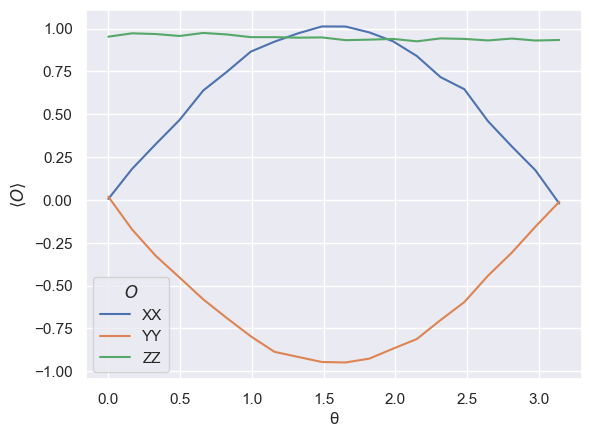

In [47]:
# Plot results
plt.plot(param_vals, evs[0], label="XX")
plt.plot(param_vals, evs[1], label="YY")
plt.plot(param_vals, evs[2], label="ZZ")
plt.xlabel("θ")
plt.ylabel(r"$\langle O \rangle$")
plt.legend(title = r"$O$")
plt.show()

#### ISA Observables

**What is an ISA observable?**

1. A linear combination of Pauli's with real coefficients
2. Each Pauli is defined on the same number of qubits as an ISA circuit

- If you are used to working with abstract observables you will need to *apply the layout* of a transpiled circuit to map the observable qubits
- Several `SparsePauliOp` and `Pauli` operator classes have an `apply_layout` method to simplify this process

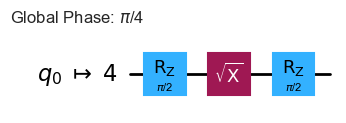

In [48]:
abstract_example = QuantumCircuit(1)
abstract_example.h(0)
isa_example = transpile(abstract_example, backend, initial_layout=[4])
isa_example.draw("mpl", idle_wires=False)

In [49]:
abstract_obs = qi.SparsePauliOp(["X", "Y", "Z"])
abstract_obs.apply_layout(isa_example.layout)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])

#### Estimator Containers

**Helper container classes**

- `ObservablesArray` and `BindingsArray` are new helper classes for manipulating these arrays
    - `ObservablesArray` is like a NumPy array of `SparsePauliOp` observables
    - `BindingsArray` is like a NumPy array for named parameter value sets
    - Have convenience methods like e.g. reshape

**Disclaimer**: These classes are *experimental*, so their API is not guaranteed to be stable

In [52]:
from qiskit.primitives.containers.observables_array import ObservablesArray

# Shape (3,1) list of Pauli Array
obs = ObservablesArray(["XX", "YY", "ZZ"]).reshape(3,1)

# Apply ISA circuit layout
# isa_obs = obs.apply_layout(isa_par_bell.layout) <= LOOKS LIKE THIS DOESN'T WORK!!!!

In [53]:
from qiskit.primitives.containers.bindings_array import BindingsArray

BindingsArray({tuple(isa_par_bell.parameters): param_vals})

BindingsArray(<shape=(20,), num_parameters=1, parameters=['θ']>)

#### Measurement Observables

**Decomposing Measurement Observables**

- IBM primitives apply Pauli grouping to minimize the number of measurement circuits
- Groups Pauli's that can be computed from marginals of a single measurement
- Grouping is done via the `PauliList.group_commuting(qubit_wise=True)`

**Component Expectation Values**

- When evaluating a Hamiltonian $H = \sum_i \alpha_i P_i$ you can also include the individual $P_i$ term expectation values
- This will incur no additional QPU time, and a minor increase in classical post-processing time

In [54]:
paulis = qi.PauliList(["ZII", "IZI", "IIZ", "XII", "IXI", "IIX", "YII", "IYI", "IIY"])
paulis.group_commuting(qubit_wise=True)

[PauliList(['ZII', 'IZI', 'IIZ']),
 PauliList(['XII', 'IXI', 'IIX']),
 PauliList(['YII', 'IYI', 'IIY'])]

In [55]:
# Want to estimate expectation value of
H = qi.SparsePauliOp(["ZII", "IZI", "IIZ"], 1/3)

# To get access to component terms as well we should set
obs = ObservablesArray([H, *H.paulis])
obs

ObservablesArray([{'ZII': np.float64(0.3333333333333333), 'IZI': np.float64(0.3333333333333333), 'IIZ': np.float64(0.3333333333333333)}
                  {'ZII': 1} {'IZI': 1} {'IIZ': 1}], shape=(4,))

#### IBM Runtime Primitives Options

- The Sampler and Estimator API described allows creation of portable programs
- The IBM runtime primitives support additional functionality which can be configured by *options*
- Enables automatic *error suppression* and *mitigation* methods

**Sampler Options**
- `default_shots`: the default shots when running Pubs
- `dynamical_decoupling`: sub-options for enabling and configuring automatic dynamical decoupling (DD)
- `twirling`: sub-options for enabling and configuring automatic Pauli-twirling

**Estimator Options**
- `default_precision`: the default precision when running Pubs
- `default_shots`: a proxy for setting default precision in terms of shots
- `resilience_level`: enable preset resilience options
- `dynamical_decoupling`: sub-options for enabling and configuring automatic dynamical decoupling (DD)
- `twirling`: sub-options for enabling and configuring automatic Pauli-twirling
- `resilience`: sub-options for enabling and configuring mitigation methods

#### Pauli Twirling

- Pauli twirling converts a general noise channel into a Pauli error channel
- Requires *transpiling* circuit to identify layers of twirled 2-qubit gates or measurements
- *Reparameterizes* the circuit to allow *parametrically inserting* random Paulis
- Samples random Paulis to insert into the circuit in a specific way
- Averages (Estimator) or concatenates (Sampler) the results over samples

#### Twirling Options

Twirling is controlled via the following twirling options:
- `enable_gates`: Whether to apply 2-qubit gate twirling
- `enable_measure`: Whether to enable twirling of measurements
- `num_randomizations`: The number of random samples to use when twirling or performing sampled mitigation
- `shots_per_randomization`: The number of shots to run for each random sample
- `strategy`: Specify the strategy of twirling qubits in identified layers of 2-qubit twirled gates

**Default Values**

If default values, the number of shots for the Pub will be divided across 32 randomizations. If values are set for `num_randomizations` and `shots_per_randomization` these values must be >= the shots for all executed Pubs.

**Twirling Strategy**

The following strategies are supported:
- `active`: Only twirl gate qubits in each layer
- `active-accum`: Twirl the accumulated gate qubits up to and including the current layer
- `active-circuit`: In each layer twirl the union of all gate qubits in the whole circuit
- `all`: In each layer twirl all qubits in the circuit, including idle qubits

In [56]:
# Set options after initializing
twirl_sampler = SamplerV2(backend)
twirl_sampler.options.twirling.enable_gates = True
twirl_sampler.options.twirling.enable_measure = True
twirl_sampler.options.twirling.strategy = "active-circuit"

# Pass-options during initialization
options = {
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "strategy": "active-circuit",
    }
}
twirl_sampler = SamplerV2(backend, options=options)

#### Estimator Resilience Sub-Options

The IBM Runtime Estimator primitives support built-in error mitigation methods

These can be enabled via the following `resilience` options:
- `measure_mitigation`: Whether to enable measurement error mitigation method
- `zne_mitigation`: Whether to turn on Zero Noise Extrapolation error mitigation method
- `pec_mitigation`: Whether to turn on Probabilisitc Error Cancellation error mitigation method

These will be covered more in later sessions

There are also sub-options for additional configuration of error mitigation:
- `zne`: Additional options for configuring ZNE mitigation
- `pec`: Additional options for configuring PEC mitigation
- `measure_noise_learning`: Addiitonal options for noise learning for measure mitigation
- `layer_noise_learning`: Additional options for noise learning for PEC mitigation

#### Estimator Resilience Levels

The IBM Runtime Estimator has built in *resilience levels* to automate option configuration

| Option | 0 | 1 | 2 |
| - | - | - | - |
| Measure Twirling | False | True | True |
| Measure Mitigation | False | True | True |
| Gate Twirling | False | False | True |
| ZNE Mitigation | False | False | True |

Default resilience levels can be further customized using the individual options

In [57]:
# Initialize estimator for ZNE
estimator = EstimatorV2(backend, options={"resilience_level": 2})

# Initialize and customize an estimator for ZNE
estimator = EstimatorV2(backend)
estimator.options.resilience_level = 2
estimator.options.dynamical_decoupling.enable = True
estimator.options.dynamical_decoupling.sequence_type = "XY4"
estimator.options.resilience.zne.extrapolator = "linear"